## Spike Prior

In this notebook we see how well the NN with dropout performs on a spike at 0, then a gaussian with s.d 1 centred at x = 5

In [1]:
import sys, pathlib, os

from SummaryStatisticNN.MainCode.generate_data import make_spike_simulator

CODE_DIR = pathlib.Path(os.getcwd()) / "MainCode"
if CODE_DIR.exists():
    sys.path.append(str(CODE_DIR.resolve()))
else:
    raise FileNotFoundError("Code directory not found")

# Module imports
from generate_data import make_spike_simulator, make_dataset
from NN import NN, GatedNN, ThetaOnly
from custom_loss import gated_loss
from plotting_functions.plot_single_dataset_posterior import make_posterior_plotter
from plotting_functions.plot_training_loss import plot_loss
from performance_metrics.average_relative_error import make_avg_rel_error_fn
from performance_metrics.sparsity_eval import evaluate_sparsity_recovery

# External imports
from tensorflow.keras.callbacks import EarlyStopping

print("successfully imported all modules")


successfully imported all modules


In [2]:
no_params = 10
epochs = 200
patience_early_stopping = 10
no_examples = 20_000
batch_size = 128

sim_cfg = dict(
    zero_prob=0.3,
    no_params=no_params,
    n_per_sample=1000,
    noise_std=0.2,
    batch_size=batch_size
)

NN_cfg = dict(
    no_params=no_params,
    neurons=[128, 128],
    dropout_probs=[0.2, 0.2],
    always_on_dropout=True
)

### Generate data

In [3]:
spike_simulator = make_spike_simulator(5, 1, **sim_cfg)
spike_train = make_dataset(int(0.9 * no_examples), spike_simulator, sim_cfg["batch_size"])
spike_val = make_dataset(int(0.1 * no_examples), spike_simulator, sim_cfg["batch_size"])

### NN for spike

In [11]:
spike_NN = NN(**NN_cfg)
spike_NN.norm.adapt(spike_train.map(lambda x, y: x))
spike_NN.compile(loss='mse', optimizer="adam")

2025-06-27 14:30:43.540701: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


### Fit NN

Epoch 1/200
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 8.4692 - val_loss: 2.8302
Epoch 2/200
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.2341 - val_loss: 1.4242
Epoch 3/200
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.3077 - val_loss: 1.1057
Epoch 4/200
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.0506 - val_loss: 0.9213
Epoch 5/200
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.9217 - val_loss: 0.8692
Epoch 6/200
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.8497 - val_loss: 0.7984
Epoch 7/200
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7945 - val_loss: 0.7679
Epoch 8/200
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7554 - val_loss: 0.7229
Epoch 9/200
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7284 - val_loss: 0.7015
Epoch 10/200
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6967 - val_loss: 0.6750
Epoch 11/200
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6794 - val_loss: 0.6656
Epoch 12/200
140/140 ━━━━━━━━━━━━━━━━━━━━

Model: "NN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_norm (Normalization)      │ (None, 121)            │           243 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        15,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ out (Dense)                     │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 100,499 (392.58 KB)

 Trainable params: 33,418 (130.54 KB)

 Non-trainable params: 243 (976.00 B)

 Optimizer params: 66,838 (261.09 KB)

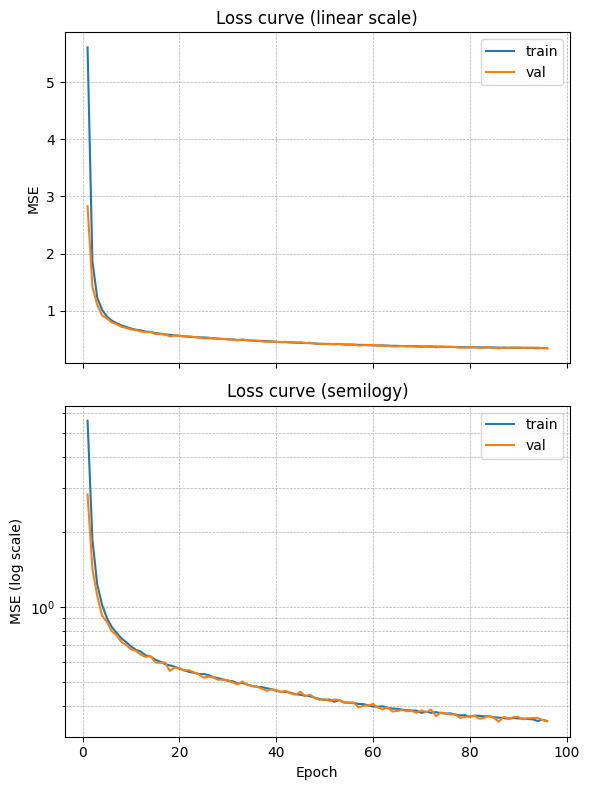

In [12]:
history = spike_NN.fit(
    spike_train.batch(batch_size),
    validation_data=spike_val.batch(batch_size),
    epochs=epochs,
    callbacks=[EarlyStopping(patience=patience_early_stopping,
                             restore_best_weights=True)]
)
spike_NN.summary()
plot_loss(history)

In [4]:
spike_avg_rel_error = make_avg_rel_error_fn(spike_simulator,
                                            batchsize=batch_size,
                                            no_tests=2_000,
                                            mc_samples=30)

In [20]:
e_spike = spike_avg_rel_error(model=spike_NN)
print(f"spike test error : {e_spike:.4f}")

spike test error : 0.0589


In [21]:
spike_plot = make_posterior_plotter(
    simulate_batch=spike_simulator,
    no_params=no_params,
    mc_samples=10_000,
    bins=40,
    show_mc_stats=True,
    xlim=[-2, 7]
)

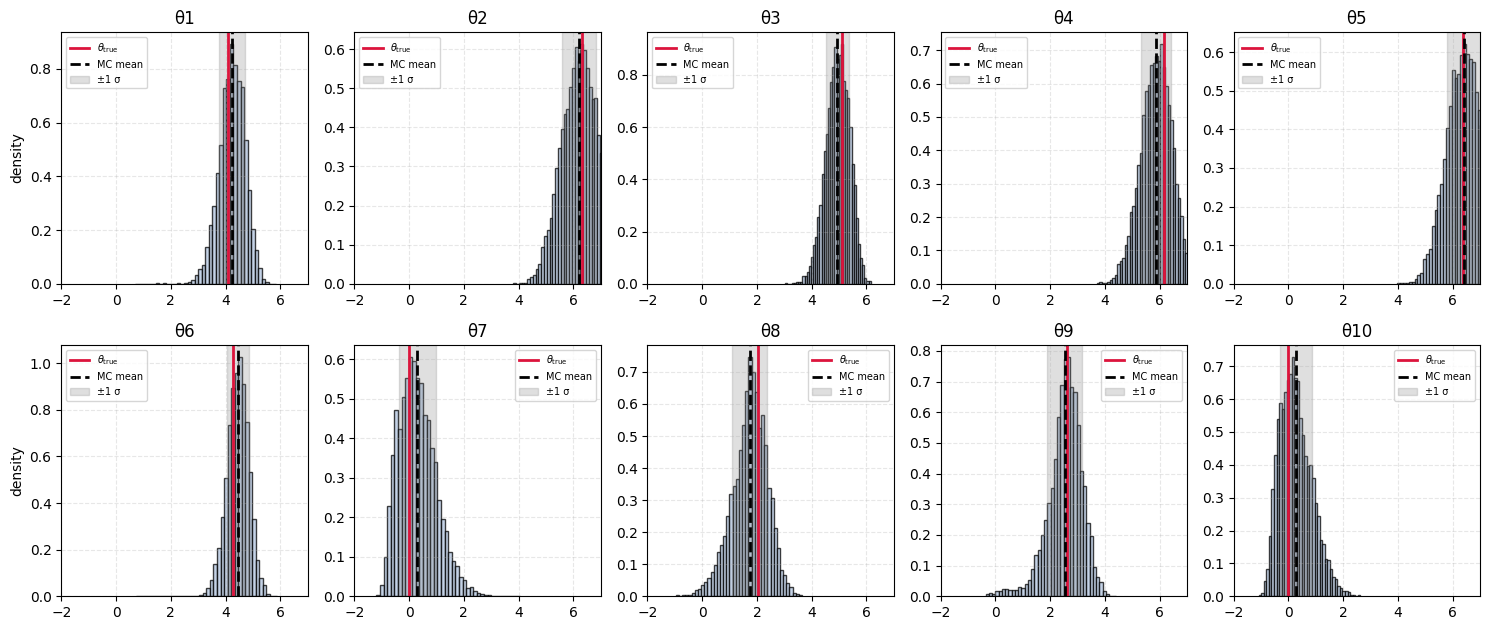

In [22]:
spike_plot(model=spike_NN)

### Try again with our new Gated NN and compare the results

In [5]:
spike_gated_NN = GatedNN(**NN_cfg)
spike_gated_NN.norm.adapt(spike_train.map(lambda x, y: x))
spike_gated_NN.compile(loss=gated_loss, optimizer="adam")

2025-06-27 14:24:23.707692: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 1/200
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 9.6237 - val_loss: 3.3805
Epoch 2/200
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.6684 - val_loss: 1.5842
Epoch 3/200
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.4023 - val_loss: 1.0720
Epoch 4/200
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0381 - val_loss: 0.9089
Epoch 5/200
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8525 - val_loss: 0.7684
Epoch 6/200
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7417 - val_loss: 0.6922
Epoch 7/200
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6698 - val_loss: 0.6295
Epoch 8/200
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6213 - val_loss: 0.5942
Epoch 9/200
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5939 - val_loss: 0.5747
Epoch 10/200
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5579 - val_loss: 0.5310
Epoch 11/200
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5379 - val_loss: 0.5275
Epoch 12/200
140/140 ━━━━━━━━━━━━━━━━━━━━

Model: "GatedNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_norm (Normalization)      │ (None, 121)            │           243 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        15,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gate (Dense)                    │ (None, 10)             │         1,290 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ value (Dense)                   │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 104,369 (407.70 KB)

 Trainable params: 34,708 (135.58 KB)

 Non-trainable params: 243 (976.00 B)

 Optimizer params: 69,418 (271.17 KB)

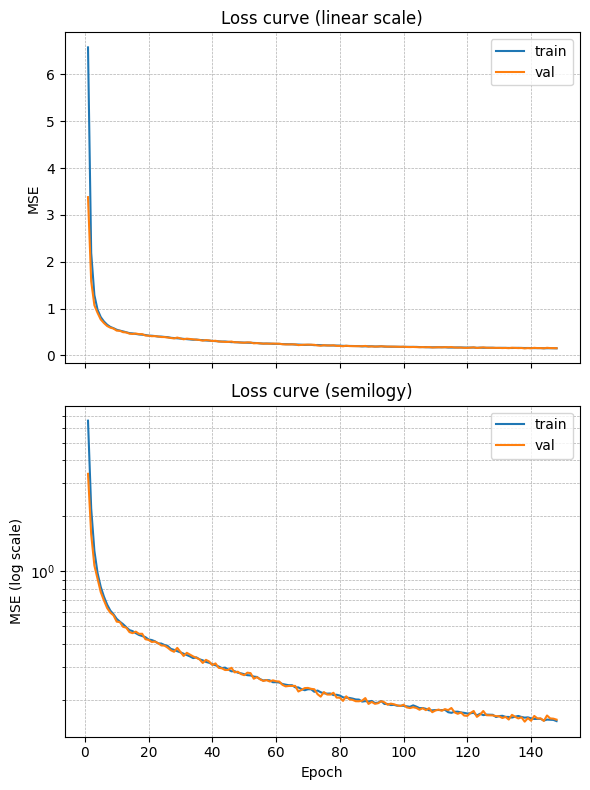

In [6]:
gated_history = spike_gated_NN.fit(
    spike_train.batch(batch_size),
    validation_data=spike_val.batch(batch_size),
    epochs=epochs,
    callbacks=[EarlyStopping(patience=patience_early_stopping,
                             restore_best_weights=True)]
)
spike_gated_NN.summary()
plot_loss(gated_history)

In [7]:
theta_only_model = ThetaOnly(spike_gated_NN)
e_gated_spike = spike_avg_rel_error(model=theta_only_model)
print(f"spike test error : {e_gated_spike:.4f}")

spike test error : 0.0507


### ERROR Results

This is a very promising result and shows that our error has decreased from before. Below we can see some plots which show that it is able to correctly identify this 0 a lot of the time.

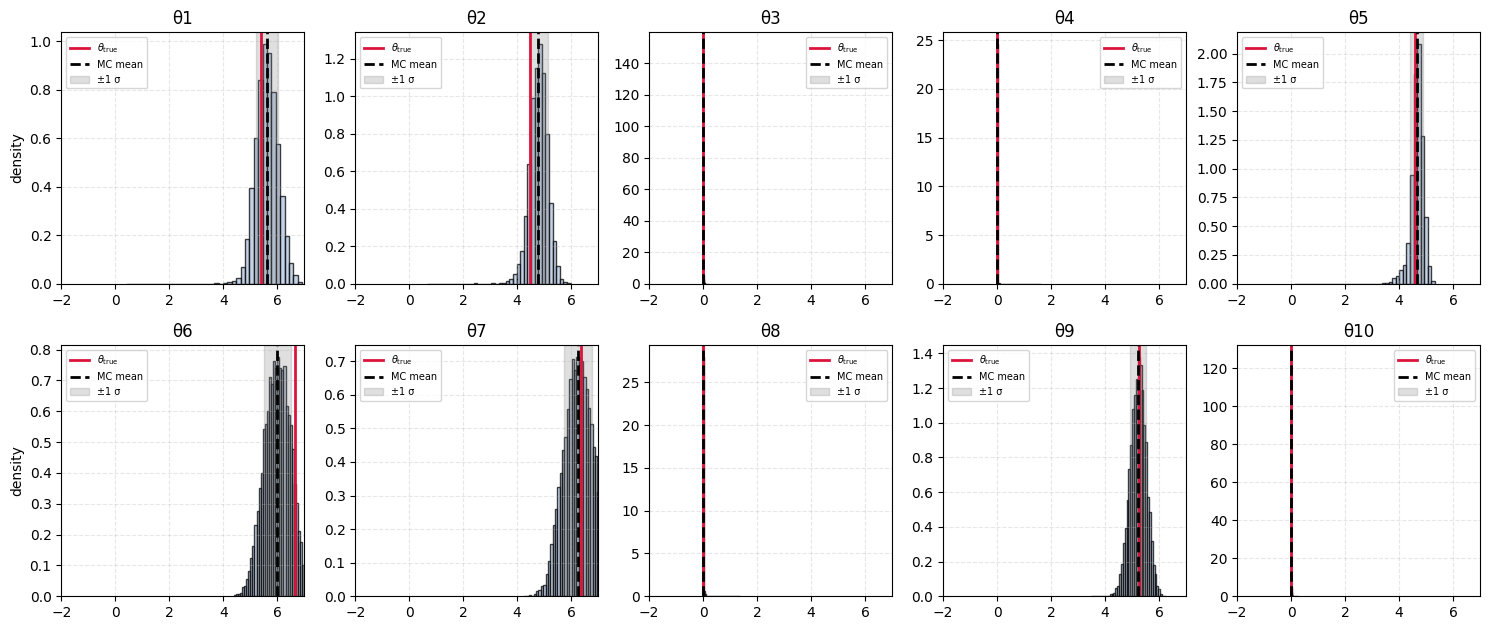

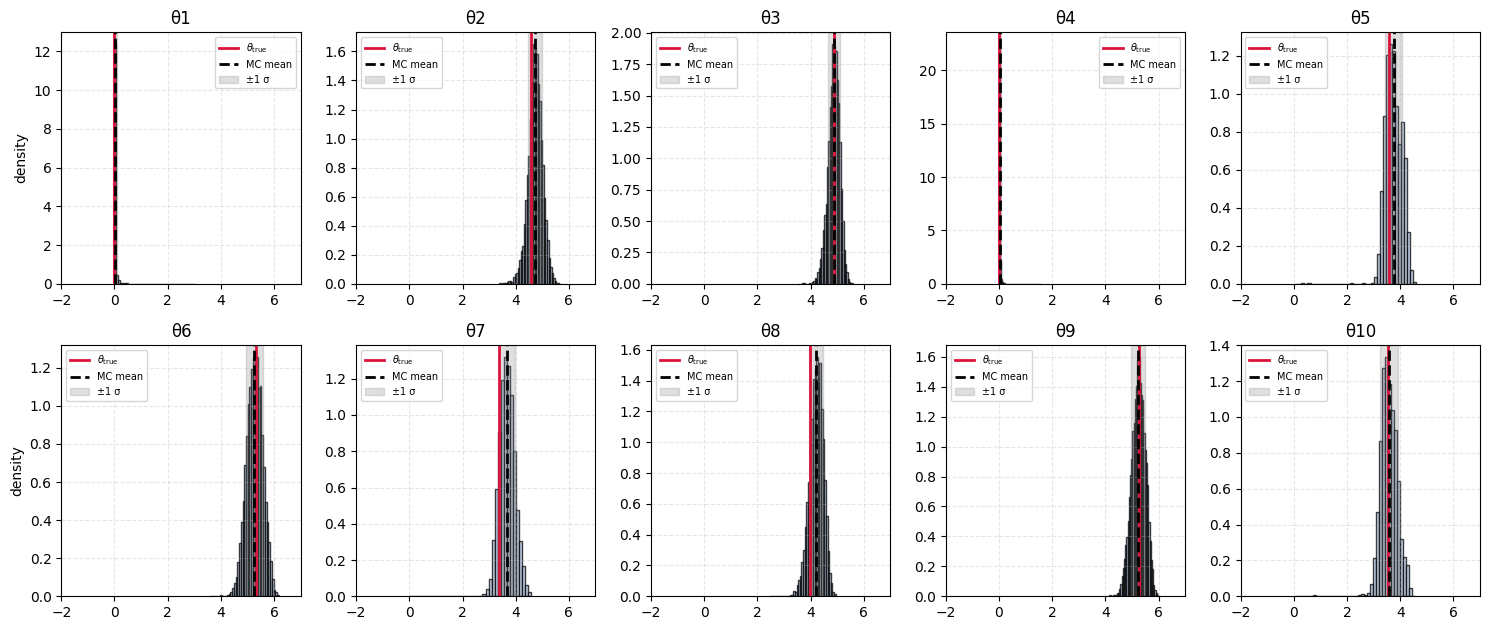

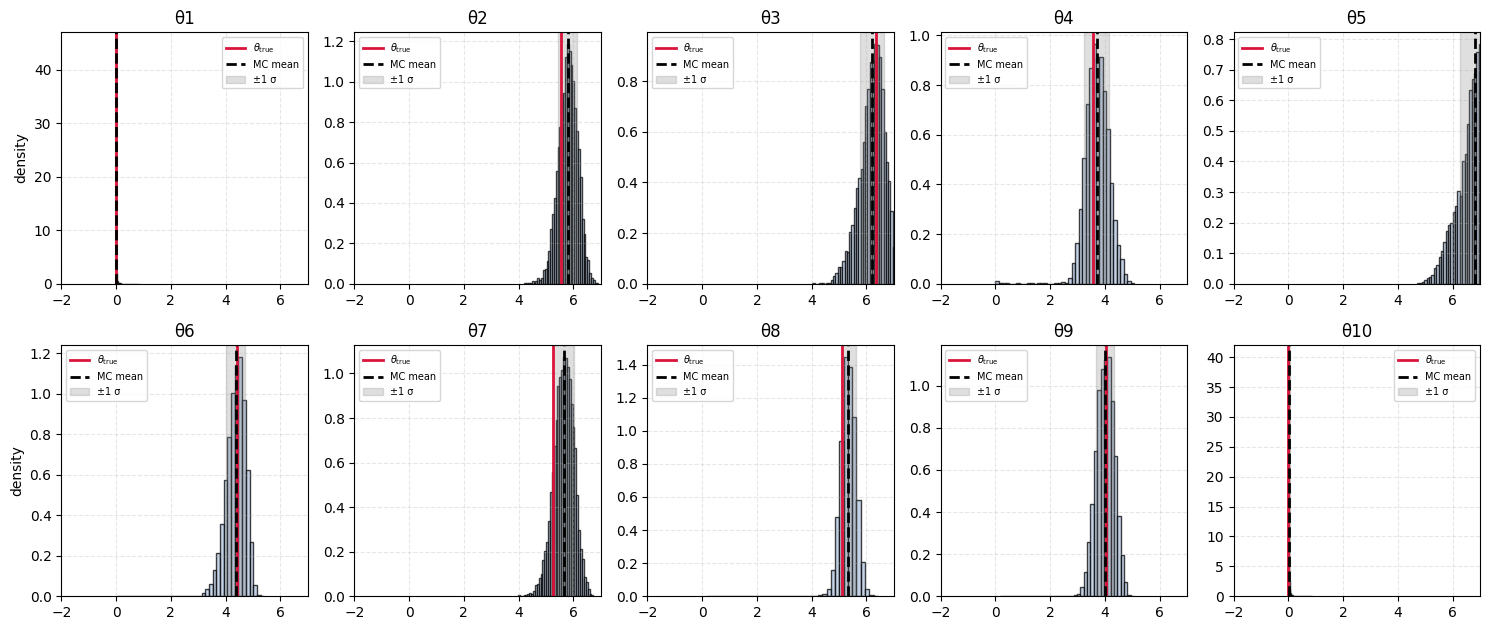

In [28]:
spike_plot(model=theta_only_model)
spike_plot(model=theta_only_model)
spike_plot(model=theta_only_model)

In [17]:
spike_sparsity = evaluate_sparsity_recovery(model=spike_NN,
                                            simulate_batch=spike_simulator,
                                            threshold=0.05,
                                            batch_size=100_000,
                                            mc_samples=50)

spike_gated_sparsity = evaluate_sparsity_recovery(model=theta_only_model,
                                                  simulate_batch=spike_simulator,
                                                  threshold=0.05,
                                                  batch_size=100_000,
                                                  mc_samples=50)

print("\nSparsity Recovery Metrics")
print("=========================")
print(f"{'Metric':<25} {'Baseline':>12} {'Gated Net':>12}")
print("-" * 51)
print(
    f"{'False positive rate':<25} {spike_sparsity['false_positive_rate']:12.4f} {spike_gated_sparsity['false_positive_rate']:12.4f}")
print(
    f"{'False negative rate':<25} {spike_sparsity['false_negative_rate']:12.4f} {spike_gated_sparsity['false_negative_rate']:12.4f}")
print(f"{'Precision':<25} {spike_sparsity['precision']:12.4f} {spike_gated_sparsity['precision']:12.4f}")
print(f"{'Recall':<25} {spike_sparsity['recall']:12.4f} {spike_gated_sparsity['recall']:12.4f}")
print(f"{'F1 score':<25} {spike_sparsity['f1_score']:12.4f} {spike_gated_sparsity['f1_score']:12.4f}")
print()



Sparsity Recovery Metrics
Metric                        Baseline    Gated Net
---------------------------------------------------
False positive rate             0.8092       0.0569
False negative rate             0.0000       0.0001
Precision                       0.7427       0.9762
Recall                          1.0000       0.9999
F1 score                        0.8524       0.9879



### Results

We see that the new gated model is significantly better at producing the desired sparsity affect with only ~5 % false positive rate compared to that of 80% for the base model. This is very encouraging but we will need to check how it performs on other priors.